In [150]:
import sys
sys.path.append('../..')

In [151]:
import torch

if torch.cuda.is_available():
    device = 'cuda'
if torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

## Dataset

In [166]:
import os
import numpy as np
from torchvision import transforms
from PIL import Image, ImageOps

from src.dataset.footprint2pressure import Footprint2Pressure_Blend

# @DATASET_REGISTRY.register()
class Footprint2Pressure_Blend_SensorPatch(Footprint2Pressure_Blend):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # transformer for resizing images
        self.resize = transforms.Resize((self.img_size, self.img_size))

        # data indexing
        self.index = []

        for subject in self.pedar_dynamic.index.get_level_values(1).drop_duplicates():
            if os.path.isfile(self.footprint_wrap_folder / f'{subject}-L.jpg'):
                for patch_id in range(1, 199):
                    self.index.append((subject, patch_id))
        
    
    def __getitem__(self, index: int, blend_weight: np.array = None) -> tuple:
        subject, sensor_id = self.index[index]
        
        # blend weights
        if blend_weight is None:
            blend_weight = np.random.rand(5)
            blend_weight = blend_weight / blend_weight.sum()

        # weight blends young modulus & pedar arrays
        arr_pedar = self.pedar_dynamic.loc[(slice(None), subject), sensor_id].values / self.sense_range
        blend_pedar = torch.tensor(
            (arr_pedar * blend_weight).sum(axis=0),
            dtype=self.dtype,
            )
        blend_young = torch.tensor(
            (np.array(list(self.material_youngs.values())) * blend_weight).sum(),
            dtype=self.dtype,
            )
        
        # load footprint image and slice out the sensor-specific patch
        if sensor_id < 99:
            img = Image.open(self.footprint_wrap_folder / f'{subject}-L.jpg')
            img_arr = np.mean(1 - np.array(img).astype(np.float64) / 255, axis=-1)
            img_patch = img_arr[self.x_grid['L'][sensor_id - 1], self.y_grid['L'][sensor_id - 1]]

        else:
            img = Image.open(self.footprint_wrap_folder / f'{subject}-R.jpg')
            img_arr = np.mean(1 - np.array(img).astype(np.float64) / 255, axis=-1)
            img_patch = img_arr[self.x_grid['L'][sensor_id - 1 - 99], self.y_grid['L'][sensor_id - 1 - 99]]
        
        img_patch = self.resize(
            torch.tensor(img_patch, dtype=self.dtype).unsqueeze(0)
            )[0]
        
        return (img_patch.to(self.device), torch.tensor(sensor_id, dtype=self.dtype).to(self.device), blend_young.to(self.device)), blend_pedar.to(self.device)

In [167]:
self = Footprint2Pressure_Blend_SensorPatch(
    device = device,
    footprint_wrap_folder = '../../data/processed/footprint-wrap/',
    pedar_dynamic_path = '../../data/processed/pedar_dynamic.pkl',
    l_mask_path = '../../data/processed/left_foot_mask.png',
    sense_range = 600,
    stack_range = 50,
    img_size = 10,
)
len(self)

9900

In [193]:
9900 / 1024

9.66796875

## Data point

In [173]:
(img_patch, sensor_id, blend_young), blend_pedar = self.__getitem__(0)
img_patch.shape, sensor_id, blend_young, blend_pedar

(torch.Size([10, 10]),
 tensor(1., device='mps:0'),
 tensor(2.2841, device='mps:0'),
 tensor(0.0575, device='mps:0'))

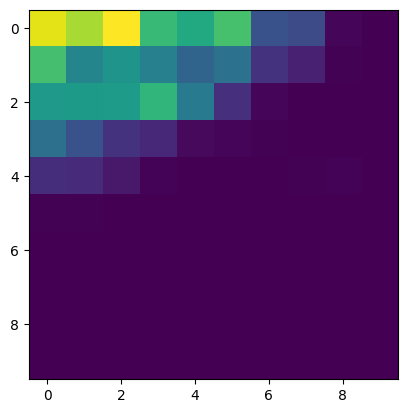

In [174]:
from matplotlib import pyplot as plt

plt.imshow(img_patch.cpu().detach().numpy())
plt.show()

## MLP adapted

In [183]:
import torch
from torch import nn

from src.model import pos_emb
from src.tool.registry import MODEL_REGISTRY

from src.model.mlp import MLP_cos_emb

# @MODEL_REGISTRY.register()
class PatchMLP_cos_emb(MLP_cos_emb):
    def forward(self, x):
        img_patch, sensor_id, young = x
        
        # reshape img_stack
        infer_shape = img_patch.shape[:-2] + (self.img_size * self.img_size,)  # e.g. (..., 10, 10) -> (..., 100)
        img_patch = img_patch.reshape(infer_shape)

        # positional embedding
        pos_emb = self.position_embedding(sensor_id)  # e.g. (50,) -> (..., 50)
        pos_emb = pos_emb.expand(img_patch.shape[:-1] + (-1,))  # e.g. (..., 50) -> (..., 50)

        # youngs' modulus embedding
        young_emb = self.young_embedding(young)  # (50,) -> (..., 50)

        x = torch.cat([img_patch, pos_emb, young_emb], dim=-1)
        
        return self.mlp(x).squeeze(-1)

In [184]:
model = PatchMLP_cos_emb(device=device)

In [185]:
model((img_patch, sensor_id, blend_young))

tensor(-0.0217, device='mps:0', grad_fn=<SqueezeBackward1>)